## Skorch and pipeline

- https://jehyunlee.github.io/2021/09/29/Python-DL-7-skorch_pipeline/

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023. 7. 13</div>
<div style="text-align: right"> Last update: 2023. 7.13</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [3]:
df_peng = sns.load_dataset("penguins")
df_peng.dropna(inplace=True)
df_peng.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [4]:
X = df_peng.drop("body_mass_g", axis = 1)
y = df_peng["body_mass_g"]
X.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,sex
0,Adelie,Torgersen,39.1,18.7,181.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,Male


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

파이프라인 구축

In [8]:
# encoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

# machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from copy import deepcopy

In [10]:
def get_model_0(X_cols, degree = 1, method = "lr"):
    
    X_cols = deepcopy(X_cols)
    
    # 1-1.categorical feature에 one-hot encoding 적용
    cat_features = list(set(X_cols) & set(["species", "island", "sex"]))
    cat_transformer = OneHotEncoder(sparse=False, handle_unknown="ignore")

    # 1-2.numerical feature는 Power Transform과 Scaler를 거침
    num_features = list(set(X_cols) - set(cat_features))
    num_features.sort()
    num_transformer = Pipeline(steps=[("polynomial", PolynomialFeatures(degree=degree)), 
                                      ("scaler", RobustScaler())
                                     ])

    # 1. 인자 종류별 전처리 적용
    preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features), 
                                                   ("cat", cat_transformer, cat_features)])
    
    # 2. 전처리 후 머신러닝 모델 적용
    if method == "lr":
        ml = LinearRegression(fit_intercept=True)
    elif method == "rf":
        ml = RandomForestRegressor()
        
        
    # 3. Pipeline
    model = Pipeline(steps=[("preprocessor", preprocessor), 
                            ("ml", ml)])
    
    return model

In [11]:
model_0 = get_model_0(list(X_train.columns), degree=1, method="lr")
model_0

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('polynomial',
                                                                   PolynomialFeatures(degree=1)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bill_depth_mm',
                                                   'bill_length_mm',
                                                   'flipper_length_mm']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['island', 'species',
                                                   'sex'])])),
                ('ml', LinearRegression())])

파이프라인 전처리 확인

In [12]:
X_train_pp = model_0["preprocessor"].fit_transform(X_train)
print(X_train_pp.shape)
X_train_pp[0]

(266, 12)


array([ 0.        , -1.2       , -0.10584958,  0.64646465,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        1.        ,  0.        ])

전처리 전후 분포 비교

Text(0.5, 0.98, ' ')

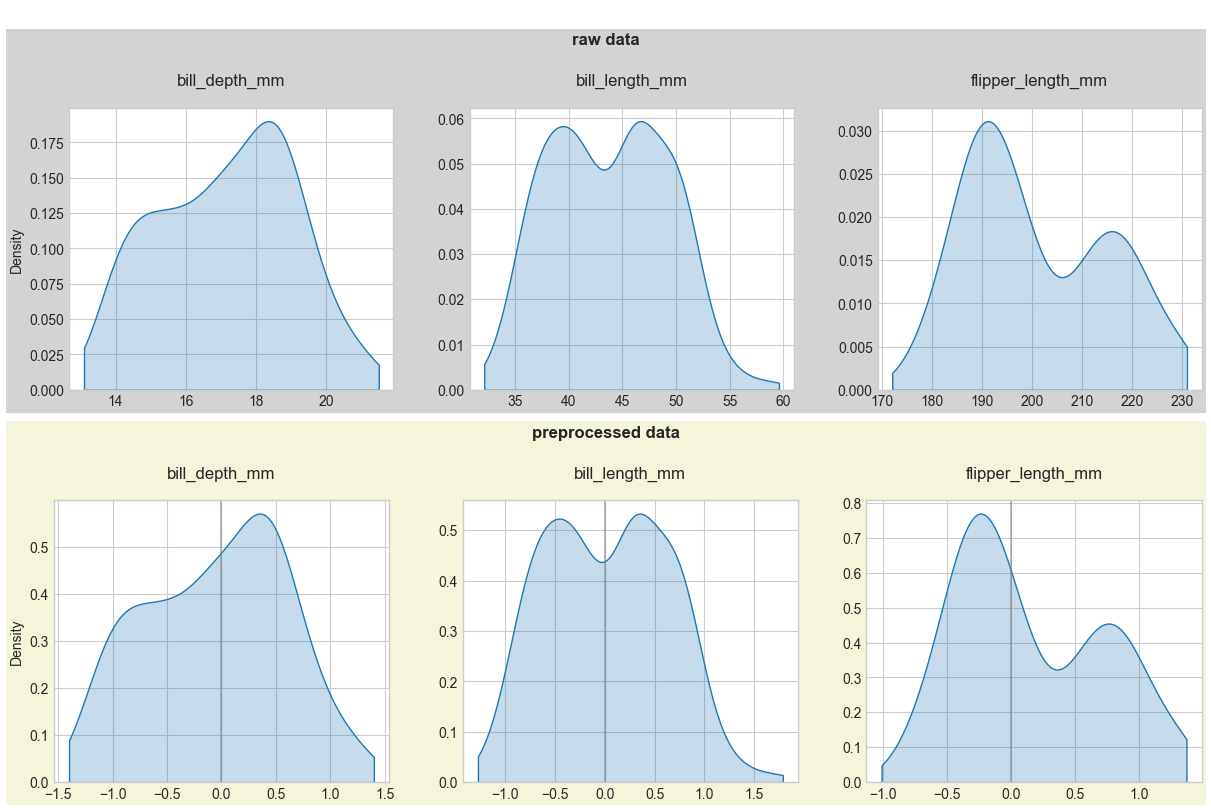

In [14]:
# Figure 생성
fig = plt.figure(figsize=(12, 8), constrained_layout=True)

# Subfigures 생성
subfigs = fig.subfigures(nrows=2, wspace=0.05)
subfigs[0].set_facecolor("lightgray")
subfigs[1].set_facecolor("beige")

# subfigs[0]: raw data
axs0 = subfigs[0].subplots(ncols=3, nrows=1)

sns.kdeplot(X_train["bill_depth_mm"], cut=0, fill=True, ax=axs0[0])
sns.kdeplot(X_train["bill_length_mm"], cut=0, fill=True, ax=axs0[1])
sns.kdeplot(X_train["flipper_length_mm"], cut=0, fill=True, ax=axs0[2])

# subfigs[1]: preprocessed data
axs1 = subfigs[1].subplots(ncols=3, nrows=1)

sns.kdeplot(X_train_pp[:,1], cut=0, fill=True, ax=axs1[0])
sns.kdeplot(X_train_pp[:,2], cut=0, fill=True, ax=axs1[1])
sns.kdeplot(X_train_pp[:,3], cut=0, fill=True, ax=axs1[2])

for ax in axs1:
    ax.axvline(0, c="gray", alpha=0.5)

for axs in [axs0, axs1]:
    for i, (ax, title) in enumerate(zip(axs, ['bill_depth_mm', 'bill_length_mm', 'flipper_length_mm'])):
        ax.set_xlabel("")
        ax.set_title(f"{title}", pad=16)
        if i > 0:
            ax.set_ylabel(" \n")

subfigs[0].suptitle("raw data\n", fontweight="bold")
subfigs[1].suptitle("preprocessed data\n", fontweight="bold")
fig.suptitle(" ")

파이프라인 학습

In [15]:
model_0.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('polynomial',
                                                                   PolynomialFeatures(degree=1)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bill_depth_mm',
                                                   'bill_length_mm',
                                                   'flipper_length_mm']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['island', 'species',
                                                   'sex'])])),
                ('ml', LinearRegression())])

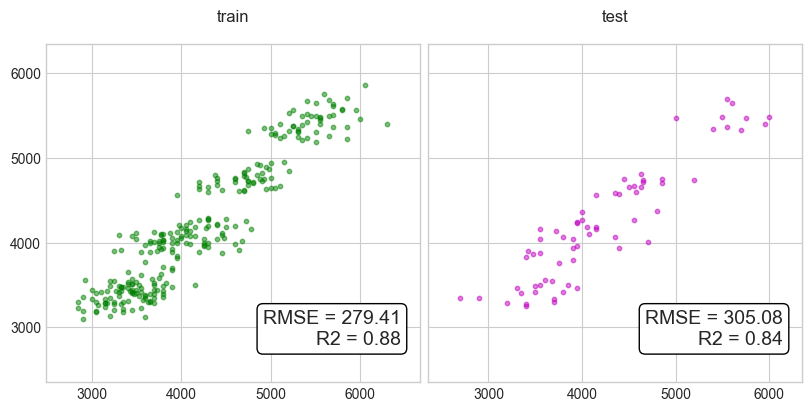

In [17]:
def plot_parity(model, y_true, y_pred=None, X_to_pred=None, ax=None, **kwargs):
    if not ax:
        fig, ax = plt.subplots(figsize=(5, 5))
    
    if y_pred is None:
        y_pred = model.predict(X_to_pred)
    ax.scatter(y_true, y_pred, **kwargs)
    xbound = ax.get_xbound()
    xticks = [x for x in ax.get_xticks() if xbound[0] <= x <= xbound[1]]
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{x:.0f}" for x in xticks])
    ax.set_yticks(xticks)
    ax.set_yticklabels([f"{x:.0f}" for x in xticks])
    dxbound = 0.05*(xbound[1]-xbound[0])
    ax.set_xlim(xbound[0]-dxbound, xbound[1]+dxbound)
    ax.set_ylim(xbound[0]-dxbound, xbound[1]+dxbound)
    
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    ax.text(0.95, 0.1, f"RMSE = {rmse:.2f}\nR2 = {r2:.2f}", transform=ax.transAxes, 
            fontsize=14, ha="right", va="bottom", bbox={"boxstyle":"round", "fc":"w", "pad":0.3})
    
    ax.grid(True)
    
    return ax
    
fig, axs = plt.subplots(ncols=2, figsize=(8, 4), constrained_layout=True, sharey=True)
plot_parity(model_0, y_train, X_to_pred=X_train, ax=axs[0], c="g", s=10, alpha=0.5)
plot_parity(model_0, y_test, X_to_pred=X_test, ax=axs[1], c="m", s=10, alpha=0.5)

for ax, title in zip(axs, ["train", "test"]):
    ax.set_title(title, pad=16)

랜덤 포레스트로 진행하기

In [18]:
model_1 = get_model_0(list(X_train.columns), degree=1, method="rf")
model_1.fit(X_train, y_train)
model_1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('polynomial',
                                                                   PolynomialFeatures(degree=1)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bill_depth_mm',
                                                   'bill_length_mm',
                                                   'flipper_length_mm']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['island', 'species',
                                                   'sex'])])),
                ('ml', RandomForestRegressor())])

일부 피처로만 학습

In [19]:
model_2 = get_model_0(["bill_length_mm", "species"], degree=1, method="rf")
model_2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('polynomial',
                                                                   PolynomialFeatures(degree=1)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bill_length_mm']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['species'])])),
                ('ml', RandomForestRegressor())])

파이토치 only

In [20]:
from torch import optim
from torch.optim.lr_scheduler import CyclicLR

import torch
import torch.nn as nn

In [21]:

class RegressorModule(nn.Module): 
    def __init__(self, ninput=11, init_weights=True):
        super(RegressorModule, self).__init__()
        
        self.model = nn.Sequential(nn.Linear(ninput, 16),
                                   nn.ReLU(),
                                   nn.Linear(16, 16),
                                   nn.ReLU(),
                                   nn.Linear(16, 12),
                                   nn.ReLU(),
                                   nn.Linear(12, 8),
                                   nn.ReLU(),
                                   nn.Linear(8, 1),
                                   )
        if init_weights:
            self._initialize_weights()
        
    def forward(self, X, **kwargs):
        return self.model(X)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [22]:
X_train_tensor = torch.Tensor(pd.get_dummies(X_train).astype(np.float32).values)
y_train_tensor = torch.Tensor(y_train.astype(np.float32).values)

In [33]:
net = RegressorModule()

class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
    
loss_func = RMSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

losses = []
for i in range(10000):
    optimizer.zero_grad()
    output = net.forward(X_train_tensor)
    loss = loss_func(output, y_train_tensor.view(-1, 1))
    loss.backward()
    optimizer.step()
    
    losses.append(loss.detach().numpy())

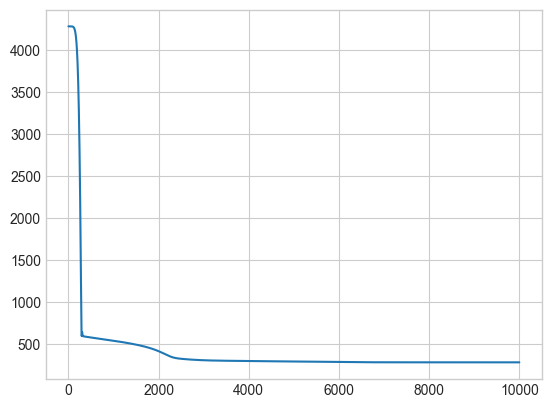

In [36]:
plt.plot(losses)

In [37]:
# numpy array를 pytorch tensor로 변환
X_test_tensor = torch.Tensor(pd.get_dummies(X_test).astype(np.float32).values)

# 예측값
y_pred_train_tensor = net.forward(X_train_tensor)
y_pred_test_tensor = net.forward(X_test_tensor)

# pytorch tensor를 다시 numpy array로 변환
y_pred_train = y_pred_train_tensor.detach().numpy()
y_pred_test = y_pred_test_tensor.detach().numpy()

파이토치 파이프라인

In [39]:
from skorch import NeuralNetRegressor
from sklearn.base import BaseEstimator, TransformerMixin

def get_model_T(X_cols, degree=1, method="lr"):
    
    X_cols_ = deepcopy(X_cols)
    
    # 1-1.categorical feature에 one-hot encoding 적용
    cat_features = list(set(X_cols) & set(["species", "island", "sex"]))
    cat_transformer = OneHotEncoder(sparse=False, handle_unknown="ignore")

    # 1-2.numerical feature는 Power Transform과 Scaler를 거침
    num_features = list(set(X_cols) - set(cat_features))
    num_features.sort()
    num_transformer = Pipeline(steps=[("polynomial", PolynomialFeatures(degree=degree)), 
                                      ("scaler", RobustScaler())
                                     ])

    # 1. 인자 종류별 전처리 적용
    preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features), 
                                                   ("cat", cat_transformer, cat_features)])
    
    # 2. float64를 float32로 변환
    class FloatTransformer(BaseEstimator, TransformerMixin):
        def __init__(self):
            pass
        def fit(self, X, y=None):
            return self
        def transform(self, x):
            return np.array(x, dtype=np.float32)
    
    # 3. 전처리 후 머신러닝 모델 적용
    if method == "lr":
        ml = LinearRegression(fit_intercept=True)
    elif method == "rf":
        ml = RandomForestRegressor()
    elif method == "torch":
        ninput = len(num_features) + 1
        if "species" in cat_features:
            ninput += 3
        if "island" in cat_features:
            ninput += 3
        if "sex" in cat_features:
            ninput += 2
            
        net = NeuralNetRegressor(RegressorModule(ninput=ninput, init_weights=False),
                         max_epochs=1000, verbose=0,
                         warm_start=True,
#                          device='cuda',
                         criterion=RMSELoss,
                         optimizer = optim.Adam,
                         optimizer__lr = 0.01
                        )
        ml = net

        
    # 3. Pipeline
    model = Pipeline(steps=[("preprocessor", preprocessor), 
                            ("float64to32", FloatTransformer()),
                            ("ml", ml)])
    
    return model

In [40]:
model_T = get_model_T(list(X_train.columns), degree=1, method="torch")
model_T.fit(X_train, y_train.astype(np.float32).values.reshape(-1, 1))
model_T

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('polynomial',
                                                                   PolynomialFeatures(degree=1)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bill_depth_mm',
                                                   'bill_length_mm',
                                                   'flipper_length_mm']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['island', 'species',
                                                   'sex'])])),
                ('float64to32', FloatTransformer()),
                ('ml',
                 <cla...d](
  module_=RegressorModule(
    (model): Sequential(
      (0): Linear(in_features=12, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=16, bias=True)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=12, bias=True)
      (5): ReLU()
      (6): Linear(in_features=12, out_features=8, bias=True)
      (7): ReLU()
      (8): Linear(in_features=8, out_features=1, bias=True)
    )
  ),
))])

### Permutation importance

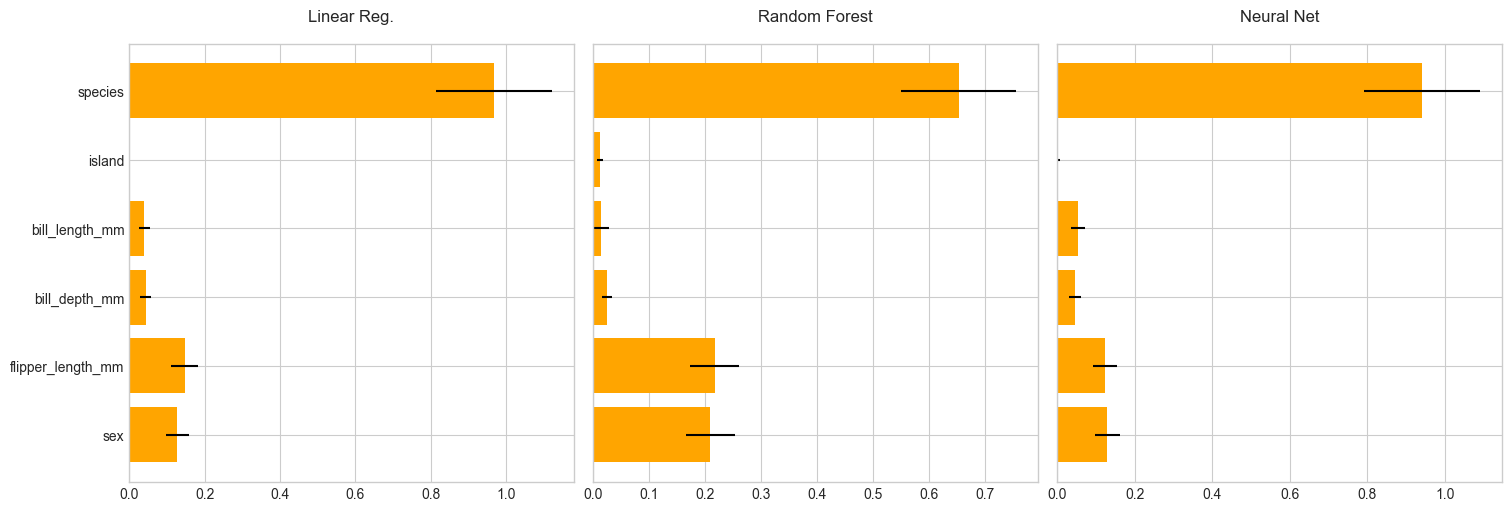

In [43]:
from sklearn.inspection import permutation_importance

# Linear Regression
pi_0 = permutation_importance(model_0, X_test, y_test, n_repeats=30, random_state=0)

# Random Forest
pi_1 = permutation_importance(model_1, X_test, y_test, n_repeats=30, random_state=0)

# Neural Network
pi_T = permutation_importance(model_T, X_test, y_test, n_repeats=30, random_state=0)

# 시각화
fig, axs = plt.subplots(ncols=3, figsize=(15, 5), constrained_layout=True, sharey=True)

for ax, pi, title in zip(axs, [pi_0, pi_1, pi_T], ["Linear Reg.", "Random Forest", "Neural Net"]):
    ax.barh(X_test.columns, pi.importances_mean, xerr=pi.importances_std, color="orange")
    ax.invert_yaxis()
    ax.set_xlim(0, )
    ax.set_title(title, pad=16)